<a href="https://colab.research.google.com/github/MakkaiNandor/IntelligensModszerekTantargy/blob/main/Mely_tanulas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from google.colab import widgets

**Adatok betöltése és megjelenítése**

Ahogy az előadáson elhangzott, neurális hálózatokat különféle felismerési feladatokra használunk. Aktuális kutatási témák közé tartozik például a COVID korai diagnózisa röntgenfelvételek alapján, ld. pl.

https://www.sciencedirect.com/science/article/abs/pii/S0169260720314140 

Ezen a gyakorlaton, annak érdekében, hogy gyorsan (1-2 perc alatt) tudjuk tanítani a neurális hálózatot, egy egyszerű felismerési feladattal foglalkozunk, kézzel írt számjegyek felismerésével, és számítások további gyorsítása érdekében az eredetileg 16x16 pixeles képeket átméretezzük 8x8 felbontású képekké.

In [2]:
data = np.loadtxt('https://archive.ics.uci.edu/ml/machine-learning-databases/semeion/semeion.data')

In [3]:
original_img_size = (16, 16)
new_img_size = (8,8)

data_8x8 = []
for i in range(len(data)):
  img_16x16 = np.reshape(data[i,0:256], original_img_size)
  img_8x8 = cv2.resize(img_16x16, new_img_size)
  img_8x8 = np.reshape(img_8x8, (64))
  data_8x8.append( img_8x8 )

data_8x8 = np.array(data_8x8)

Néhány átméretezett képet megjelenítünk szürkeárnyalatos képként.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

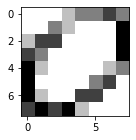

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

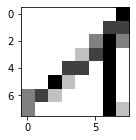

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

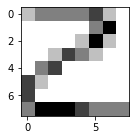

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

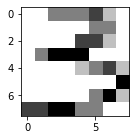

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

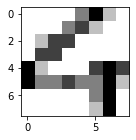

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

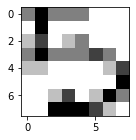

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

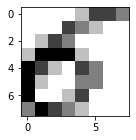

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

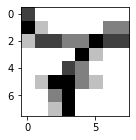

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

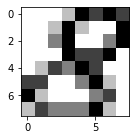

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

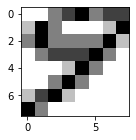

<IPython.core.display.Javascript object>

In [4]:
tb = widgets.TabBar([str(i) for i in range(10)], location='top')
for i in range(10):
  with tb.output_to(i):
    an_image = np.reshape(data_8x8[200+i*20], new_img_size )
    plt.figure(figsize=(2,2))
    plt.imshow(1-an_image, cmap='gray', vmin=0, vmax=1)
    plt.show()

Felosztjuk az adatainkat tanító és teszt adatokra. Az utolsó 500 példány lesz a teszt adathalmaz, a többi a tanítóhalmaz.

In [5]:
train_data = data_8x8[:1093,0:64]
train_labels = data[:1093,256:266]
test_data = data_8x8[1093:,0:64]
test_labels = data[1093:,256:266]

**A modell definiálása**

A köveketkezők feladatok során a most definiált neurális hálóból fogunk kiindulni. A bemeneti réteg unit-jainak száma 64, mert egy-egy kép 8x8=64 pixelt tartalmaz. A háló két belső réteggel rendelkezik, ezek 100 ill. 50 unitot tartalmaznak. A kimeneti rétegben a 10 osztály mindegyikének egy-egy unit felel meg. Definiálnunk kell a neurális háló által elvégzett számítást leíró forward(...) függvényt is. 

In [6]:
class DigitRecognizer(nn.Module):
    def __init__(self):
        super(DigitRecognizer, self).__init__()
        num_units_h1 = 100
        num_units_h2 = 50

        self.fc1 = nn.Linear(64, num_units_h1)
        self.fc2 = nn.Linear(num_units_h1, num_units_h2)
        self.out = nn.Linear(num_units_h2, 10) 

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.out(x)
        return x

**A háló tanítása:**
- a tanítóadatoból létrehozunk egy tensor datasetet, amelyet egy DataLoader-en keresztül fogunk elérni,
- példányosítjuk a hálót,
- megadjuk a célfüggvényt,
- példányosítjuk az optimalizáló algoritmust,
- végül a tanítóadatokon végighaladva az egyes batchekre elvégezzük az optimalizációs algoritmus egy-egy lépését (for ciklus)

In [7]:
train_dataset = torch.utils.data.TensorDataset(
    torch.Tensor(train_data), torch.Tensor(train_labels) )
trainloader = torch.utils.data.DataLoader(
    train_dataset, shuffle=True, batch_size=16)

net = DigitRecognizer()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-2)

running_loss = 0.0
running_n = 0

for epoch in range(1000):  
  for inputs, targets in trainloader:
    optimizer.zero_grad()
    
    outputs = net(inputs)

    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    running_n = running_n + 1

  #print('epoch %d, loss: %.3f' % (epoch + 1, running_loss / running_n))
  running_loss = 0.0
  running_n = 0   

**A háló pontosságának mérése**

Megnézzük, hogy a tesztpéldányok közül hányat sikerül helyesen osztályozni.

In [8]:
def eval_net(net):
  test_dataset = torch.utils.data.TensorDataset( 
        torch.Tensor(test_data), torch.Tensor(test_labels))
  testloader = torch.utils.data.DataLoader(test_dataset)

  correct = 0
  total = 0

  with torch.no_grad():
    for inputs, targets in testloader:
      outputs = net(inputs)
      _, predicted = torch.max(outputs.data, 1)
      _, targets_ordinal = torch.max(targets, 1)
      
      total += targets.size(0)
      correct += (predicted == targets_ordinal)

  return float(correct/total)

In [9]:
eval_net(net)

0.9039999842643738

**1. feladat: aktivációs függvények a rejtett rétegekben** 

Az előbbi neurális hálóban cserélje ki az első és második rejtett rétegbeli aktivációs függvényt 

(a) szigmoid (torch.sigmoid),

(b) softplus (torch.nn.functional.softplus),

(c) Leaky ReLU (torch.nn.functional.leaky_relu),

(d) Leaky ReLU 0.2-es negatív meredekséggel (negative_slope=0.2),

(e) tangens hiperbolicus (torch.tanh)

függvényre. Tanítsa és értékelje ki a hálózatot! 

In [12]:
class DigitRecognizer(nn.Module):
    def __init__(self):
        super(DigitRecognizer, self).__init__()
        num_units_h1 = 100
        num_units_h2 = 50

        self.fc1 = nn.Linear(64, num_units_h1)
        self.fc2 = nn.Linear(num_units_h1, num_units_h2)
        self.out = nn.Linear(num_units_h2, 10) 

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.out(x)
        return x

train_dataset = torch.utils.data.TensorDataset(
    torch.Tensor(train_data), torch.Tensor(train_labels) )
trainloader = torch.utils.data.DataLoader(
    train_dataset, shuffle=True, batch_size=16)

net = DigitRecognizer()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-2)

running_loss = 0.0
running_n = 0

for epoch in range(1000):  
  for inputs, targets in trainloader:
    optimizer.zero_grad()
    
    outputs = net(inputs)

    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    running_n = running_n + 1

  #print('epoch %d, loss: %.3f' % (epoch + 1, running_loss / running_n))
  running_loss = 0.0
  running_n = 0   

In [14]:
eval_net(net)

0.5860000252723694

In [17]:
class DigitRecognizer(nn.Module):
    def __init__(self):
        super(DigitRecognizer, self).__init__()
        num_units_h1 = 100
        num_units_h2 = 50

        self.fc1 = nn.Linear(64, num_units_h1)
        self.fc2 = nn.Linear(num_units_h1, num_units_h2)
        self.out = nn.Linear(num_units_h2, 10) 

    def forward(self, x):
        x = torch.nn.functional.softplus(self.fc1(x))
        x = torch.nn.functional.softplus(self.fc2(x))
        x = self.out(x)
        return x

train_dataset = torch.utils.data.TensorDataset(
    torch.Tensor(train_data), torch.Tensor(train_labels) )
trainloader = torch.utils.data.DataLoader(
    train_dataset, shuffle=True, batch_size=16)

net = DigitRecognizer()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-2)

running_loss = 0.0
running_n = 0

for epoch in range(1000):  
  for inputs, targets in trainloader:
    optimizer.zero_grad()
    
    outputs = net(inputs)

    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    running_n = running_n + 1

  #print('epoch %d, loss: %.3f' % (epoch + 1, running_loss / running_n))
  running_loss = 0.0
  running_n = 0   

In [18]:
eval_net(net)

0.8840000033378601

In [19]:
class DigitRecognizer(nn.Module):
    def __init__(self):
        super(DigitRecognizer, self).__init__()
        num_units_h1 = 100
        num_units_h2 = 50

        self.fc1 = nn.Linear(64, num_units_h1)
        self.fc2 = nn.Linear(num_units_h1, num_units_h2)
        self.out = nn.Linear(num_units_h2, 10) 

    def forward(self, x):
        x = torch.nn.functional.leaky_relu(self.fc1(x))
        x = torch.nn.functional.leaky_relu(self.fc2(x))
        x = self.out(x)
        return x

train_dataset = torch.utils.data.TensorDataset(
    torch.Tensor(train_data), torch.Tensor(train_labels) )
trainloader = torch.utils.data.DataLoader(
    train_dataset, shuffle=True, batch_size=16)

net = DigitRecognizer()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-2)

running_loss = 0.0
running_n = 0

for epoch in range(1000):  
  for inputs, targets in trainloader:
    optimizer.zero_grad()
    
    outputs = net(inputs)

    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    running_n = running_n + 1

  #print('epoch %d, loss: %.3f' % (epoch + 1, running_loss / running_n))
  running_loss = 0.0
  running_n = 0   

In [20]:
eval_net(net)

0.8920000195503235

In [21]:
class DigitRecognizer(nn.Module):
    def __init__(self):
        super(DigitRecognizer, self).__init__()
        num_units_h1 = 100
        num_units_h2 = 50

        self.fc1 = nn.Linear(64, num_units_h1)
        self.fc2 = nn.Linear(num_units_h1, num_units_h2)
        self.out = nn.Linear(num_units_h2, 10) 

    def forward(self, x):
        x = torch.nn.functional.leaky_relu(self.fc1(x), negative_slope=0.2)
        x = torch.nn.functional.leaky_relu(self.fc2(x), negative_slope=0.2)
        x = self.out(x)
        return x

train_dataset = torch.utils.data.TensorDataset(
    torch.Tensor(train_data), torch.Tensor(train_labels) )
trainloader = torch.utils.data.DataLoader(
    train_dataset, shuffle=True, batch_size=16)

net = DigitRecognizer()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-2)

running_loss = 0.0
running_n = 0

for epoch in range(1000):  
  for inputs, targets in trainloader:
    optimizer.zero_grad()
    
    outputs = net(inputs)

    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    running_n = running_n + 1

  #print('epoch %d, loss: %.3f' % (epoch + 1, running_loss / running_n))
  running_loss = 0.0
  running_n = 0   

In [22]:
eval_net(net)

0.9039999842643738

In [23]:
class DigitRecognizer(nn.Module):
    def __init__(self):
        super(DigitRecognizer, self).__init__()
        num_units_h1 = 100
        num_units_h2 = 50

        self.fc1 = nn.Linear(64, num_units_h1)
        self.fc2 = nn.Linear(num_units_h1, num_units_h2)
        self.out = nn.Linear(num_units_h2, 10) 

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.out(x)
        return x

train_dataset = torch.utils.data.TensorDataset(
    torch.Tensor(train_data), torch.Tensor(train_labels) )
trainloader = torch.utils.data.DataLoader(
    train_dataset, shuffle=True, batch_size=16)

net = DigitRecognizer()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-2)

running_loss = 0.0
running_n = 0

for epoch in range(1000):  
  for inputs, targets in trainloader:
    optimizer.zero_grad()
    
    outputs = net(inputs)

    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    running_n = running_n + 1

  #print('epoch %d, loss: %.3f' % (epoch + 1, running_loss / running_n))
  running_loss = 0.0
  running_n = 0   

In [24]:
eval_net(net)

0.8799999952316284

**2. feladat: hibafüggvény**

A neurális háló tanítása során eredetileg kereszt-entrópiát ("binary cross entropy with logits loss") használtuk hibafüggvényként. Tanítsa a hálót a négyzetes hibák átlagát (nn.MSELoss) használva és értékelje ki a háló teljesítményét!

In [25]:
class DigitRecognizer(nn.Module):
    def __init__(self):
        super(DigitRecognizer, self).__init__()
        num_units_h1 = 100
        num_units_h2 = 50

        self.fc1 = nn.Linear(64, num_units_h1)
        self.fc2 = nn.Linear(num_units_h1, num_units_h2)
        self.out = nn.Linear(num_units_h2, 10) 

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.out(x)
        return x

train_dataset = torch.utils.data.TensorDataset(
    torch.Tensor(train_data), torch.Tensor(train_labels) )
trainloader = torch.utils.data.DataLoader(
    train_dataset, shuffle=True, batch_size=16)

net = DigitRecognizer()
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=1e-2)

running_loss = 0.0
running_n = 0

for epoch in range(1000):  
  for inputs, targets in trainloader:
    optimizer.zero_grad()
    
    outputs = net(inputs)

    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    running_n = running_n + 1

  #print('epoch %d, loss: %.3f' % (epoch + 1, running_loss / running_n))
  running_loss = 0.0
  running_n = 0   

In [26]:
eval_net(net)

0.906000018119812

**3. feladat: optimalizáló algoritmus**

(a) A stochastic gradient descent és minibatch gradient descent algoritmusok egyik előnytelen tulajdonsága, hogy nem garantált, hogy az optimális irányba "lépünk" a paraméterek értékeinek frissítésekor. Sőt előfordulhat, hogy "össze-vissza" lépkedünk, egyszer a "jó" megoldás irányába, máskor egy masik irányba. Ezen próbál javítani a momentumok használata: momentumok használata esetén az aktuális javító lépés nem kizárólag az adott minibatch során számolt gradiensből adódik, hanem figyelembe vesszük a korábbi javítólépéseket is. Minél nagyobb a momentum értéke, annál többet számítanak a korábbi javítólépések, annál kevésbe fogunk "össze-vissza" ugrálni, azaz "egyenletesebben" haladunk a megoldás irányába. Paraméterezze az optimalizációs algoritmust úgy, hogy 0.2-es értékű momentumot használjon és értékelje ki a kapott hálót!

(b) Használjon 0.8-as értékű momentumot és hasonlítsa össze a kapott haló teljesítményét az előbbi hálóéval!

(c) SGD helyett használja az ADAM (ADAptive Moments) optimalizációs algoritmust (optim.Adam)! 

In [27]:
class DigitRecognizer(nn.Module):
    def __init__(self):
        super(DigitRecognizer, self).__init__()
        num_units_h1 = 100
        num_units_h2 = 50

        self.fc1 = nn.Linear(64, num_units_h1)
        self.fc2 = nn.Linear(num_units_h1, num_units_h2)
        self.out = nn.Linear(num_units_h2, 10) 

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.out(x)
        return x

train_dataset = torch.utils.data.TensorDataset(
    torch.Tensor(train_data), torch.Tensor(train_labels) )
trainloader = torch.utils.data.DataLoader(
    train_dataset, shuffle=True, batch_size=16)

net = DigitRecognizer()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.2)

running_loss = 0.0
running_n = 0

for epoch in range(1000):  
  for inputs, targets in trainloader:
    optimizer.zero_grad()
    
    outputs = net(inputs)

    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    running_n = running_n + 1

  #print('epoch %d, loss: %.3f' % (epoch + 1, running_loss / running_n))
  running_loss = 0.0
  running_n = 0   

In [28]:
eval_net(net)

0.8999999761581421

In [29]:
class DigitRecognizer(nn.Module):
    def __init__(self):
        super(DigitRecognizer, self).__init__()
        num_units_h1 = 100
        num_units_h2 = 50

        self.fc1 = nn.Linear(64, num_units_h1)
        self.fc2 = nn.Linear(num_units_h1, num_units_h2)
        self.out = nn.Linear(num_units_h2, 10) 

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.out(x)
        return x

train_dataset = torch.utils.data.TensorDataset(
    torch.Tensor(train_data), torch.Tensor(train_labels) )
trainloader = torch.utils.data.DataLoader(
    train_dataset, shuffle=True, batch_size=16)

net = DigitRecognizer()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.8)

running_loss = 0.0
running_n = 0

for epoch in range(1000):  
  for inputs, targets in trainloader:
    optimizer.zero_grad()
    
    outputs = net(inputs)

    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    running_n = running_n + 1

  #print('epoch %d, loss: %.3f' % (epoch + 1, running_loss / running_n))
  running_loss = 0.0
  running_n = 0   

In [30]:
eval_net(net)

0.9100000262260437

In [31]:
class DigitRecognizer(nn.Module):
    def __init__(self):
        super(DigitRecognizer, self).__init__()
        num_units_h1 = 100
        num_units_h2 = 50

        self.fc1 = nn.Linear(64, num_units_h1)
        self.fc2 = nn.Linear(num_units_h1, num_units_h2)
        self.out = nn.Linear(num_units_h2, 10) 

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.out(x)
        return x

train_dataset = torch.utils.data.TensorDataset(
    torch.Tensor(train_data), torch.Tensor(train_labels) )
trainloader = torch.utils.data.DataLoader(
    train_dataset, shuffle=True, batch_size=16)

net = DigitRecognizer()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-2)

running_loss = 0.0
running_n = 0

for epoch in range(1000):  
  for inputs, targets in trainloader:
    optimizer.zero_grad()
    
    outputs = net(inputs)

    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    running_n = running_n + 1

  #print('epoch %d, loss: %.3f' % (epoch + 1, running_loss / running_n))
  running_loss = 0.0
  running_n = 0   

In [32]:
eval_net(net)

0.9160000085830688

**4. feladat: Tanulási ráta csökkentése**

Kezdetben, amíg "messze" vagyunk a "jó" megoldástól, érdemes lehet nagyobb tanulási rátát használni, részben azért, hogy gyorsan jussunk a "jó" megoldás közelébe, részeben pedig azért, hogy a hibafüggvény lokális minimumait "átugorjuk". (Lineáris regresszióval ellentétben a neurális hálók tanítása általában nem konvex otpimalizációs feladat.)

A torch.optim.lr_scheduler.StepLR-t használva csökkentse minden 10-dik epoch végén 10%-kal a tanulási rátát, a kezdeti tanulási rátát állítsa 0.05-re! Tanítsa majd értékelje ki a hálózatot! Ha szükséges, nézze tanulmányozza a dokumentációt: https://pytorch.org/docs/stable/optim.html 

In [37]:
class DigitRecognizer(nn.Module):
    def __init__(self):
        super(DigitRecognizer, self).__init__()
        num_units_h1 = 100
        num_units_h2 = 50

        self.fc1 = nn.Linear(64, num_units_h1)
        self.fc2 = nn.Linear(num_units_h1, num_units_h2)
        self.out = nn.Linear(num_units_h2, 10) 

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.out(x)
        return x

train_dataset = torch.utils.data.TensorDataset(
    torch.Tensor(train_data), torch.Tensor(train_labels) )
trainloader = torch.utils.data.DataLoader(
    train_dataset, shuffle=True, batch_size=16)

net = DigitRecognizer()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=0.05)

running_loss = 0.0
running_n = 0

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

for epoch in range(1000):  
  for inputs, targets in trainloader:
    optimizer.zero_grad()
    
    outputs = net(inputs)

    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    running_n = running_n + 1

  scheduler.step()

  #print('epoch %d, loss: %.3f' % (epoch + 1, running_loss / running_n))
  running_loss = 0.0
  running_n = 0   

In [38]:
eval_net(net)

0.8539999723434448

**5. feladat: regularizáció**

(a) Early stop: minden tanítóepoch végén értékelje ki a neurális hálózatot, és határozza meg, hány epochig érdemes tanítani a legjobb pontosság eléréséhez. Az epoch végén végzett kiértékelés eredménye a hálózat tényleges pontosságának torzítatlan becslése lesz-e?

(b) Az optimalizációs algoritmus paraméterezésével valósítson meg L2 regularizációt (az előadáson használt jelölések szerint) lambda=0.01 súllyal (Pytorch-ban "lambda" elnevezése: "weight_decay").

(c) Dropout (nn.Dropout) réteg bevezetésével valósítson meg dropout-ot a második rejtett réteget követően!

In [39]:
class DigitRecognizer(nn.Module):
    def __init__(self):
        super(DigitRecognizer, self).__init__()
        num_units_h1 = 100
        num_units_h2 = 50

        self.fc1 = nn.Linear(64, num_units_h1)
        self.fc2 = nn.Linear(num_units_h1, num_units_h2)
        self.out = nn.Linear(num_units_h2, 10) 

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.out(x)
        return x

train_dataset = torch.utils.data.TensorDataset(
    torch.Tensor(train_data), torch.Tensor(train_labels) )
trainloader = torch.utils.data.DataLoader(
    train_dataset, shuffle=True, batch_size=16)

net = DigitRecognizer()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-2, weight_decay=0.01)

running_loss = 0.0
running_n = 0

for epoch in range(1000):  
  for inputs, targets in trainloader:
    optimizer.zero_grad()
    
    outputs = net(inputs)

    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    running_n = running_n + 1

  #print('epoch %d, loss: %.3f' % (epoch + 1, running_loss / running_n))
  running_loss = 0.0
  running_n = 0   

In [40]:
eval_net(net)

0.07999999821186066

**6. feladat: Mély Neurális Hálózatok**

Definiáljon egy modellt, amelynek 4 rejtett rétege van, minden rejtett rétegben 100 unit legyen. Tanítsa a modellt és értékelje ki a modell pontosságát!


In [41]:
class DigitRecognizer(nn.Module):
    def __init__(self):
        super(DigitRecognizer, self).__init__()
        num_units_h1 = 100
        num_units_h2 = 100
        num_units_h3 = 100
        num_units_h4 = 100

        self.fc1 = nn.Linear(64, num_units_h1)
        self.fc2 = nn.Linear(num_units_h1, num_units_h2)
        self.fc3 = nn.Linear(num_units_h2, num_units_h3)
        self.fc4 = nn.Linear(num_units_h3, num_units_h4)
        self.out = nn.Linear(num_units_h4, 10) 

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.out(x)
        return x

train_dataset = torch.utils.data.TensorDataset(
    torch.Tensor(train_data), torch.Tensor(train_labels) )
trainloader = torch.utils.data.DataLoader(
    train_dataset, shuffle=True, batch_size=16)

net = DigitRecognizer()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-2)

running_loss = 0.0
running_n = 0

for epoch in range(1000):  
  for inputs, targets in trainloader:
    optimizer.zero_grad()
    
    outputs = net(inputs)

    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    running_n = running_n + 1

  #print('epoch %d, loss: %.3f' % (epoch + 1, running_loss / running_n))
  running_loss = 0.0
  running_n = 0   

KeyboardInterrupt: ignored

In [ ]:
eval_net(net)

**7. feladat: Konvolúciós hálózatok**

Adott az alábbi konvolúciós neurális hálózat. Tanulmányozza a kódot, majd hajtsa végre az alábbi módosításokat. Mindegyik módosítás után  tanítsa és értékelje ki a hálót!

(a) Mennyi most a konvolúciós szűrők (más néven: *filterek*, vagy a konvolúció műveletének *kimeneti csatornáinak* száma)? Növelje meg a konvolúciós szűrők számát 10-re!

(b) Milyen méretű lokális mintázat felismerésére képes egy-egy konvolúciós szűrő? Növelje meg a kernel méretét 5x5-ösre! 

(c) Töltse fel a kép szélét nullákkal olyan módon, hogy a kép felbontása ne változzon a konvolúció során! (Tipp: *padding* állítása)

(d) A konvolúciót követően vezessen be egy 2x2-es max pooling réteget! (Tipp: használja az *nn.MaxPool2d*-t!)

(e) A gyorsabb tanítás érdekében helyettesítse a max pooling réteget azzal, hogy a konvolúció lépéstávolságát 1-ről 2-re növeli! (Tipp: *stride* állítása)

In [ ]:
class DigitRecognizerCNN(nn.Module):
    def __init__(self):
        super(DigitRecognizerCNN, self).__init__()
        num_units_fc = 25

        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 5, 
                               kernel_size=(3,3))
        self.fc = nn.Linear(5*6*6, num_units_fc)
        self.out = nn.Linear(num_units_fc, 10) 

    def forward(self, x):
        x = x.view(-1, 1, 8, 8)
        x = self.conv1(x)
        x = x.view(-1, 5*6*6)
        x = torch.relu(self.fc(x))
        x = self.out(x)
        return x

In [ ]:
train_dataset = torch.utils.data.TensorDataset(
    torch.Tensor(train_data), torch.Tensor(train_labels) )
trainloader = torch.utils.data.DataLoader(
    train_dataset, shuffle=True, batch_size=16)

net = DigitRecognizerCNN()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

running_loss = 0.0
running_n = 0

best_acc = 0
best_epoch = 0

for epoch in range(1000):  
  for inputs, targets in trainloader:
    optimizer.zero_grad()
    
    outputs = net(inputs)

    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    running_n = running_n + 1

In [ ]:
eval_net(net)

**Ajánlott irodalom**

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html